In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp drive/My\ Drive/stylee.jpg /content/


In [0]:
!ls

content.jpg  drive  images  sample_data  stylee.jpg


In [0]:
import numpy as np
from keras.applications import vgg16
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import cv2 as cv
import time
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


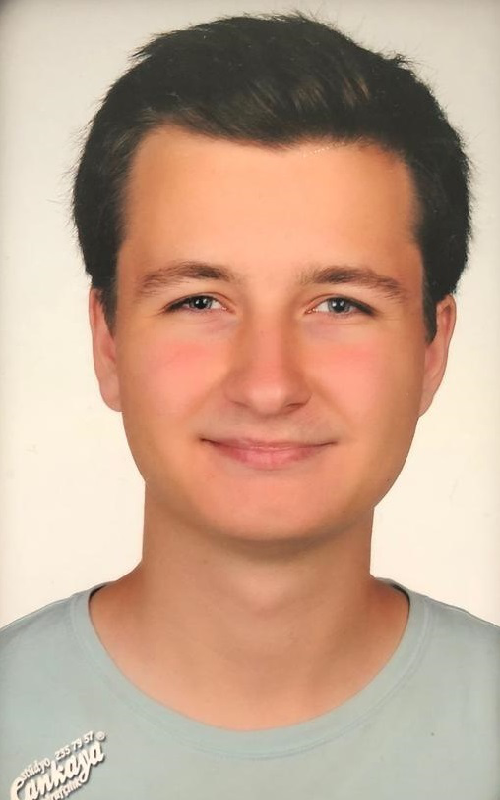

In [0]:
# Import Base and Style images and resize them into same dimension
width = 500
height = 800

content_image_path = 'content.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

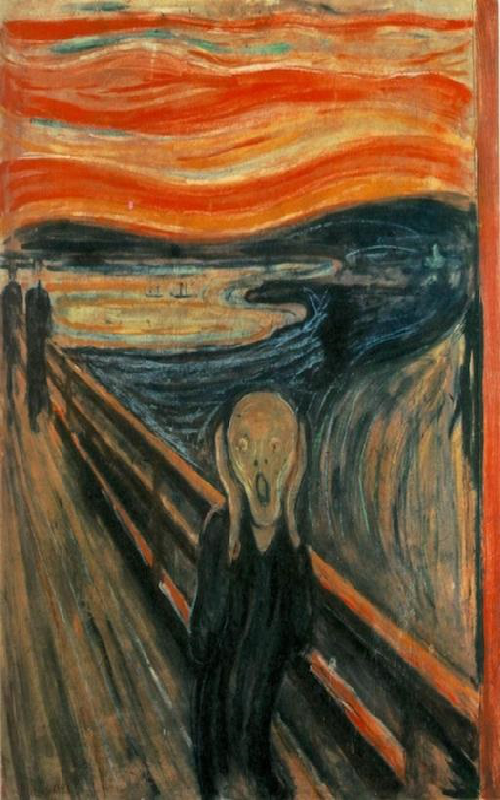

In [0]:
style_image_path = 'style.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [0]:
# Add one more dimension to concatinate the images
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 800, 500, 3)
(1, 800, 500, 3)


In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [0]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)
combination_image = K.placeholder((1, height, width, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
input_tensor = K.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [0]:
# Create instance of pre-trained VGG16 Classifier model, do not include last layer
model = vgg16.VGG16(input_tensor=input_tensor, weights="imagenet", include_top=False)
print("Model Loaded")

58892288/58889256 [==============================] - 4s 0us/step
Model Loaded


In [0]:
# Layers in VGG16 listed
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [0]:
# Weights of losses, these are hyperparameters of our algorithm
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [0]:
########################   C O N T E N T   L O S S   ###########################

In [0]:
# Calculate the Content Loss, extract the activations from CNN
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

# Calculate the OLS error between combined image and content image
content_loss = K.sum(K.square(combination_features - content_image_features))
loss = K.variable(0.)
loss = content_weight * content_loss

In [0]:
#########################   S T Y L E   L O S S   #############################

In [0]:
# Calculate Gram Matrix of given matrix (X*X^T)
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [0]:
def style_loss(style, combination):
    style_gram = gram_matrix(style)
    content_gram = gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(style_gram - content_gram)) / (4. * (channels ** 2) * (size ** 2))

# Layers used to calculate style loss
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

# Sum the losses we get from each layer for the style loss
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [0]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# Calculate gradients of the total loss w.r.t. combined image
gradients = K.gradients(loss, combination_image)

In [0]:
outputs = [loss]
outputs += gradients
f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [0]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 49658733000.0
Iteration 0 completed in 35s
Start of iteration 1
Current loss value: 21262666000.0
Iteration 1 completed in 24s
Start of iteration 2
Current loss value: 16390339000.0
Iteration 2 completed in 24s
Start of iteration 3
Current loss value: 14631184000.0
Iteration 3 completed in 24s
Start of iteration 4
Current loss value: 13734597000.0
Iteration 4 completed in 24s
Start of iteration 5
Current loss value: 13070152000.0
Iteration 5 completed in 24s
Start of iteration 6
Current loss value: 12673288000.0
Iteration 6 completed in 24s
Start of iteration 7
Current loss value: 12392255000.0
Iteration 7 completed in 24s
Start of iteration 8
Current loss value: 12203021000.0
Iteration 8 completed in 24s
Start of iteration 9
Current loss value: 12079737000.0
Iteration 9 completed in 24s


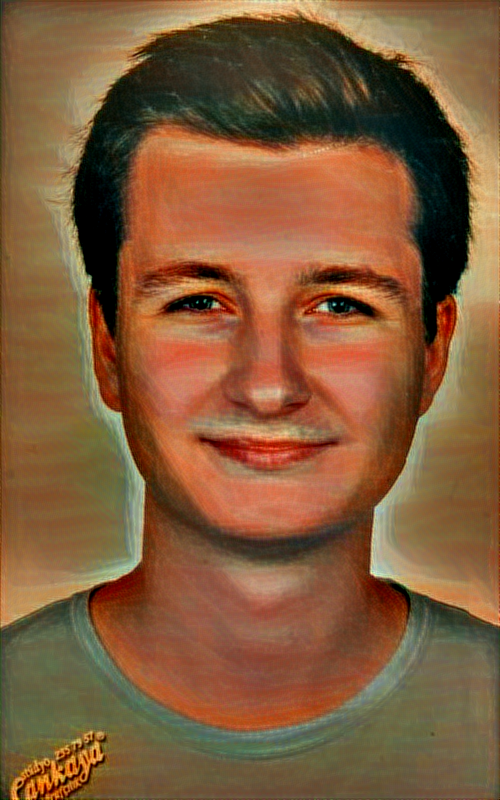

In [0]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103
x[:, :, 1] += 116
x[:, :, 2] += 123
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)

In [1]:
cv.imwrite("output.jpg", x)
!cp /content/output.jpg drive/My\ Drive/

NameError: ignored